## Rascunho do Porjeto : Segmentação por RFM + Clusters

🍔 **Análise de Segmentação de Usuários em Plataforma de Delivery**

**Dashboard Iterativa em** : https://analise-e-segmentacao-clientes.onrender.com/

Com o crescimento acelerado dos serviços de entrega online, compreender os perfis de clientes se tornou essencial para garantir experiências personalizadas e aumentar a fidelização. Pensando nisso, o presente projeto propõe uma análise de segmentação de usuários com base em dados simulados de uma aplicação de delivery.

O conjunto de dados utilizado neste projeto é de uma base de dados do aplicativo  **Wolt**, uma empresa de **entrega de alimentos e mercadorias**, semelhante ao **iFood**, que atua em diversos países e foi adquirida pela **DoorDash** em **2022**. **A Wol**t é conhecida por sua atuação no mercado europeu e escandinavo, oferecendo uma plataforma robusta de pedidos online.


O conjunto de dados representa usuários únicos que se cadastraram na plataforma entre **setembro de 2019 e outubro de 2020**. Alguns realizaram pedidos ao longo do período, enquanto outros permaneceram inativos. A partir dessas informações, será possível identificar padrões de comportamento de consumo.

Para conduzir essa segmentação, utilizaremos a **metodologia RFM (Recência, Frequência e Monetariedade)**, que permite agrupar os clientes conforme sua atividade de compra. Isso inclui a última vez que compraram, quantas vezes fizeram pedidos e quanto gastaram no total. Com essa abordagem, será possível distinguir os clientes mais engajados, aqueles em risco de abandono e os que podem ser estimulados com estratégias específicas.

Esses grupos servirão como base para ações direcionadas, como oferecer incentivos para reativar usuários inativos ou recompensas para manter os mais fiéis. A análise também dará suporte para decisões estratégicas relacionadas a campanhas de marketing e otimização de serviços.

### Passos necessários :

**Etapas do Projeto**

- Exploração inicial dos dados

- Limpeza e padronização das informações

- Cálculo dos indicadores RFM

- Ajuste e normalização dos dados para clusterização

- Aplicação do algoritmo K-Means com validação (método do cotovelo)

- Análise dos clusters gerados



**Bibliotecas Necessarias**

In [ ]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import (
    MaxAbsScaler,
    MinMaxScaler,
    Normalizer,
    PowerTransformer,
    QuantileTransformer,
    RobustScaler,
    StandardScaler,
    minmax_scale,
)
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from yellowbrick.cluster.elbow import kelbow_visualizer
from yellowbrick.datasets.loaders import load_nfl
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt


Função super util para observar valores nulos

In [ ]:
def revisao_colunas(df):

    nulos = df.isnull().sum()  # Conta valores nulos por coluna
    tipos_colunas = df.dtypes  # Tipos de dados por coluna
    porcentagem = round((nulos / len(df)) * 100, 2)  # Porcentagem de dados ausentes

    resumo = pd.DataFrame({
        "Tipo": tipos_colunas,
        "Nulos": nulos,
        "Dados ausentes %": porcentagem
    })
    print(resumo.sort_values(by = "Dados ausentes %", ascending = False))

Função para

In [ ]:
# Essa função calcula o tempo (em dias) que os usuários levaram para fazer a primeira compra após o registro.
# Em seguida, ela gera uma tabela com a contagem de quantas vezes cada tempo de espera ocorreu
# e a porcentagem que cada tempo representa em relação ao total de usuários.

def primeira_compra(df):
    # Extrai as datas de registro e da primeira compra
    data_registro = df['registration_date']
    data_primeira_compra = df['first_purchase_day']

    # Calcula a diferença em dias entre o registro e a primeira compra
    dias_espera = data_primeira_compra - data_registro
    total = len(dias_espera)  # Total de registros (usuários)

    # Cria um DataFrame com os dias de espera e uma coluna de contagem
    tabela_espera = pd.DataFrame({
        "Dias de espera": dias_espera,
        "Contagem": 1
    })

    # Agrupa os dados pela quantidade de dias de espera e conta quantas vezes cada valor aparece
    contagem_dias = (
        tabela_espera
        .groupby(["Dias de espera"])
        .count()
        .sort_values("Contagem", ascending=False)
    )

    # Remove o índice anterior e calcula a porcentagem de cada tempo de espera
    contagem_dias.reset_index(drop=True, inplace=True)
    contagem_dias["Porcentagem %"] = (contagem_dias["Contagem"] / total) * 100

    return contagem_dias


**Cores**

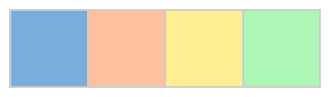

In [ ]:
# paleta customizada
customPalette = ['#79ADDC','#FFC09F','#FFEE93','#ADF7B6']
sns.set_palette(customPalette)
sns.palplot(customPalette)

# para plotly
colors=['#bad0af','#d5e0cf','#f1f1f1','#f1d4d4']

## Pre-Processamento e Analise Exploratoria de Dados.


In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/geovatatsuga/analise-e-segmentacao-clientes/refs/heads/main/DADOS/dataset_for_analyst_assignment_20201120.csv')
df.head()
print(list(df))

['REGISTRATION_DATE', 'REGISTRATION_COUNTRY', 'PURCHASE_COUNT', 'PURCHASE_COUNT_DELIVERY', 'PURCHASE_COUNT_TAKEAWAY', 'FIRST_PURCHASE_DAY', 'LAST_PURCHASE_DAY', 'USER_ID', 'BREAKFAST_PURCHASES', 'LUNCH_PURCHASES', 'EVENING_PURCHASES', 'DINNER_PURCHASES', 'LATE_NIGHT_PURCHASES', 'TOTAL_PURCHASES_EUR', 'DISTINCT_PURCHASE_VENUE_COUNT', 'MIN_PURCHASE_VALUE_EUR', 'MAX_PURCHASE_VALUE_EUR', 'AVG_PURCHASE_VALUE_EUR', 'PREFERRED_DEVICE', 'IOS_PURCHASES', 'WEB_PURCHASES', 'ANDROID_PURCHASES', 'PREFERRED_RESTAURANT_TYPES', 'USER_HAS_VALID_PAYMENT_METHOD', 'MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE', 'MOST_COMMON_WEEKDAY_TO_PURCHASE', 'AVG_DAYS_BETWEEN_PURCHASES', 'MEDIAN_DAYS_BETWEEN_PURCHASES', 'AVERAGE_DELIVERY_DISTANCE_KMS', 'PURCHASE_COUNT_BY_STORE_TYPE']


In [ ]:
# transformando colunas para letra minuscula
df.columns = df.columns.str.lower()
df

,registration_date,registration_country,purchase_count,purchase_count_delivery,purchase_count_takeaway,first_purchase_day,last_purchase_day,user_id,breakfast_purchases,lunch_purchases,...,web_purchases,android_purchases,preferred_restaurant_types,user_has_valid_payment_method,most_common_hour_of_the_day_to_purchase,most_common_weekday_to_purchase,avg_days_between_purchases,median_days_between_purchases,average_delivery_distance_kms,purchase_count_by_store_type
0,2019-09-01 00:00:00.000,DNK,0,NaN,NaN,NaN,NaN,1,NaN,NaN,...,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,"{\n ""General merchandise"": 0,\n ""Grocery"": 0..."
1,2019-09-01 00:00:00.000,FIN,1,1.0,0.0,2020-09-02 00:00:00.000,2020-09-02 00:00:00.000,2,0.0,1.0,...,0.0,1.0,NaN,False,23.0,2.0,NaN,NaN,6.853,"{\n ""General merchandise"": 0,\n ""Grocery"": 0..."
2,2019-09-01 00:00:00.000,DNK,19,19.0,0.0,2019-12-10 00:00:00.000,2020-05-25 00:00:00.000,3,0.0,4.0,...,19.0,0.0,NaN,True,21.0,2.0,9.0,3.0,6.559,"{\n ""General merchandise"": 1,\n ""Grocery"": 9..."
3,2019-09-01 00:00:00.000,FIN,0,NaN,NaN,NaN,NaN,4,NaN,NaN,...,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,"{\n ""General merchandise"": 0,\n ""Grocery"": 0..."
4,2019-09-01 00:00:00.000,GRC,0,NaN,NaN,NaN,NaN,5,NaN,NaN,...,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,"{\n ""General merchandise"": 0,\n ""Grocery"": 0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21978,2019-09-30 00:00:00.000,GRC,1,1.0,0.0,2020-01-23 00:00:00.000,2020-01-23 00:00:00.000,21979,0.0,0.0,...,0.0,1.0,NaN,False,12.0,2.0,NaN,NaN,1.383,"{\n ""General merchandise"": 0,\n ""Grocery"": 0..."
21979,2019-09-30 00:00:00.000,GRC,0,NaN,NaN,NaN,NaN,21980,NaN,NaN,...,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,"{\n ""General merchandise"": 0,\n ""Grocery"": 0..."
21980,2019-09-30 00:00:00.000,DNK,0,NaN,NaN,NaN,NaN,21981,NaN,NaN,...,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,"{\n ""General merchandise"": 0,\n ""Grocery"": 0..."
21981,2019-09-30 00:00:00.000,DNK,0,NaN,NaN,NaN,NaN,21982,NaN,NaN,...,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,"{\n ""General merchandise"": 0,\n ""Grocery"": 0..."


In [ ]:
total_usuarios = len(df)
total_usuarios

21983

In [ ]:
# Carrega o tipo de loja : purchase_count_by_store_type, em json
import json

# Converter JSON string para dict diretamente e expandir
compras_df = pd.json_normalize(df['purchase_count_by_store_type'].apply(json.loads))
compras_df


,General merchandise,Grocery,Pet supplies,Restaurant,Retail store
0,0,0,0,0,0
1,0,0,0,1,0
2,1,9,0,9,0
3,0,0,0,0,0
4,0,0,0,0,0
...,...,...,...,...,...
21978,0,0,0,1,0
21979,0,0,0,0,0
21980,0,0,0,0,0
21981,0,0,0,0,0


In [ ]:
# Soma total de compras em cada categoria
total_compras_por_categoria = compras_df.sum()
compras_porcentagem = (total_compras_por_categoria / total_compras_por_categoria.sum()) * 100

# DataFrame 2: Total de compras e % por categoria
df_compras = pd.DataFrame({
    'Total de compras': total_compras_por_categoria,
    'Compras (%)': compras_porcentagem.round(2)
})

df_compras

,Total de compras,Compras (%)
General merchandise,1442,1.96
Grocery,12707,17.28
Pet supplies,175,0.24
Restaurant,44692,60.77
Retail store,14525,19.75


In [ ]:
# Ordena os dados por porcentagem de compras
df_compras_sorted = df_compras.sort_values('Compras (%)', ascending=True)

# Tradução dos nomes das categorias
traducao_categorias = {
    'General merchandise': 'Mercadoria geral',
    'Grocery': 'Mercado',
    'Pet supplies': 'Produtos para pets',
    'Restaurant': 'Restaurante',
    'Retail store': 'Loja de varejo'
}

# Aplicando a tradução aos rótulos do eixo X
categorias = [traducao_categorias.get(cat, cat) for cat in df_compras_sorted.index]
valores = df_compras_sorted['Compras (%)'].values

# Gerando degradê de laranja com base nos valores normalizados
norm = (valores - np.min(valores)) / (np.max(valores) - np.min(valores))
cores = [f'rgba(255, {int(180 - n * 100)}, 0, 1)' for n in norm]

# Criando o gráfico de linha
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=categorias,
    y=valores,
    mode='lines+markers',
    line=dict(
        width=3,
        color='orange'
    ),
    marker=dict(
        size=12,
        color=cores,
        line=dict(width=2, color='white')
    ),
    text=[f'{v:.2f}%' for v in valores],
    hoverinfo='text+x'
))

# Layout com fundo branco
fig.update_layout(
    title='Distribuição do Total de Compras por Categoria',
    title_font=dict(family='Montserrat, Arial', size=20, color='black'),
    xaxis=dict(title='Categoria', color='black', showgrid=True, gridcolor='lightgray'),
    yaxis=dict(title='Porcentagem (%)', color='black', gridcolor='lightgray'),
    plot_bgcolor='white',
    paper_bgcolor='white',
    font=dict(family='Montserrat, Arial', size=14, color='black'),
    height=500,
    width=800
)

fig.show()


Limpeza de Dados e Primeiros achados


In [ ]:
# faz a junção de compras_df com o df
df = pd.merge(df, compras_df, left_index=True, right_index=True)
df = df.drop(['purchase_count_by_store_type'],axis=1)
df.columns = df.columns.str.lower()
df.head()

,registration_date,registration_country,purchase_count,purchase_count_delivery,purchase_count_takeaway,first_purchase_day,last_purchase_day,user_id,breakfast_purchases,lunch_purchases,...,most_common_hour_of_the_day_to_purchase,most_common_weekday_to_purchase,avg_days_between_purchases,median_days_between_purchases,average_delivery_distance_kms,general merchandise,grocery,pet supplies,restaurant,retail store
0,2019-09-01 00:00:00.000,DNK,0,NaN,NaN,NaN,NaN,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
1,2019-09-01 00:00:00.000,FIN,1,1.0,0.0,2020-09-02 00:00:00.000,2020-09-02 00:00:00.000,2,0.0,1.0,...,23.0,2.0,NaN,NaN,6.853,0,0,0,1,0
2,2019-09-01 00:00:00.000,DNK,19,19.0,0.0,2019-12-10 00:00:00.000,2020-05-25 00:00:00.000,3,0.0,4.0,...,21.0,2.0,9.0,3.0,6.559,1,9,0,9,0
3,2019-09-01 00:00:00.000,FIN,0,NaN,NaN,NaN,NaN,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
4,2019-09-01 00:00:00.000,GRC,0,NaN,NaN,NaN,NaN,5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0


In [ ]:
revisao_colunas(df)


                                            Tipo  Nulos  Dados ausentes %
preferred_restaurant_types                object  19289             87.75
avg_days_between_purchases               float64  14151             64.37
median_days_between_purchases            float64  14151             64.37
first_purchase_day                        object  10019             45.58
last_purchase_day                         object   9956             45.29
purchase_count_takeaway                  float64   9955             45.28
late_night_purchases                     float64   9955             45.28
dinner_purchases                         float64   9955             45.28
total_purchases_eur                      float64   9955             45.28
evening_purchases                        float64   9955             45.28
distinct_purchase_venue_count            float64   9955             45.28
lunch_purchases                          float64   9955             45.28
breakfast_purchases                   

In [ ]:
#EXCLUINDO AS 3 COLUNAS COM MAIS DADOS AUSENTES

df.drop(["preferred_restaurant_types","median_days_between_purchases","avg_days_between_purchases"],axis=1,inplace=True)
df.dropna(inplace=True)

👉 Importante: esta análise considera apenas os usuários que já realizaram pelo menos uma compra.
Antes de excluir os que nunca compraram, é essencial verificar se eles representam uma parcela relevante que possa impactar análises futuras.

In [ ]:
df_novos_clientes = df[df['purchase_count']== 0]
df = df[df['purchase_count'] != 0]

# Converte 'registration_date' 'first_purchase_day' e 'last_purchase_day' para datetime
df['registration_date'] = pd.to_datetime(df['registration_date']).dt.date
df['first_purchase_day'] = pd.to_datetime(df['first_purchase_day']).dt.date
df['last_purchase_day'] = pd.to_datetime(df['last_purchase_day']).dt.date


Venda gasto total por categoria

In [ ]:
# Define as colunas das categorias de compras
categorias = ['general merchandise', 'grocery', 'pet supplies', 'restaurant', 'retail store']

# Seleciona os dados relevantes
compras_por_categoria = df[categorias]
total_compras_usuario = compras_por_categoria.sum(axis=1)

# Calcula a proporção de cada categoria por usuário
proporcao = compras_por_categoria.div(total_compras_usuario, axis=0).fillna(0)

# Distribui o valor total gasto proporcionalmente entre as categorias
gasto_proporcional = proporcao.mul(df['total_purchases_eur'], axis=0)

# Soma o total gasto por categoria
gasto_total_eur_por_categoria = gasto_proporcional.sum().sort_values(ascending=False)

# Formata em DataFrame final
gasto_c_total_eur_df = gasto_total_eur_por_categoria.reset_index()
gasto_c_total_eur_df.columns = ['Categoria', 'Total Gasto (€)']
gasto_c_total_eur_df['Total Gasto (€)'] = gasto_c_total_eur_df['Total Gasto (€)'].map(lambda x: f"€ {x:,.2f}")
gasto_c_total_eur_df

,Categoria,Total Gasto (€)
0,restaurant,"€ 1,307,423.89"
1,retail store,"€ 403,240.00"
2,grocery,"€ 352,588.22"
3,general merchandise,"€ 43,660.76"
4,pet supplies,"€ 4,382.25"


In [ ]:
# Define as colunas de categorias com nomes em minúsculo
categorias = ['general merchandise', 'grocery', 'pet supplies', 'restaurant', 'retail store']

# Soma total de compras em cada categoria
total_compras_por_categoria = df[categorias].sum()

# Calcula a porcentagem de participação de cada categoria
compras_porcentagem = (total_compras_por_categoria / total_compras_por_categoria.sum()) * 100

# Cria o DataFrame final com totais e porcentagens
df_compras = pd.DataFrame({
    'Total de pedidos': total_compras_por_categoria,
    'Compras (%)': compras_porcentagem.round(2)
})
df_compras = df_compras.sort_values('Compras (%)', ascending=True)
df_compras


,Total de compras,Compras (%)
pet supplies,175,0.24
general merchandise,1440,1.96
grocery,12695,17.31
retail store,14502,19.77
restaurant,44539,60.72


In [ ]:
import plotly.graph_objects as go

# Dados
categorias = gasto_c_total_eur_df['Categoria'].tolist()
valores_eur = gasto_c_total_eur_df['Total Gasto (€)'].str.replace('€', '').str.replace(',', '').astype(float)
percentuais = [df_compras.loc[cat, 'Compras (%)'] for cat in categorias]

# Cores degradê (escuro = maior valor)
cores_degrade = ['#FB8C00', '#FFA726', '#FFB74D', '#FFCC80', '#FFE0B2']

# Função para abreviar os valores
def abreviar_valor(v):
    if v >= 1_000_000:
        return f"€{v/1_000_000:.1f}M"
    elif v >= 1_000:
        return f"€{v/1_000:.0f}K"
    else:
        return f"€{v:.0f}"

# Texto do resumo (categoria: valor • porcentagem)
texto_resumo = "<br>".join([
    f"{cat.title()}: <b>{abreviar_valor(val)}</b> • {perc:.1f}%"
    for cat, val, perc in zip(categorias, valores_eur, percentuais)
])

# Gráfico
fig = go.Figure()

# Barras
fig.add_trace(go.Bar(
    x=categorias,
    y=valores_eur,
    name='Total Gasto (€)',
    marker=dict(color=cores_degrade),
    text=[abreviar_valor(v) for v in valores_eur],
    textposition='inside',
    insidetextanchor='end',
    width=0.5,
    yaxis='y1'
))

# Linha
fig.add_trace(go.Scatter(
    x=categorias,
    y=percentuais,
    name='Porcentagem de Compras (%)',
    mode='lines+markers+text',
    line=dict(color='red', width=3),
    marker=dict(size=10, color='red'),
    text=[f"{v:.1f}%" for v in percentuais],
    textposition='top center',
    yaxis='y2'
))

# Layout
fig.update_layout(
    title='Total Gasto (€) e Porcentagem de Compras por Categoria',
    xaxis=dict(title='Categoria'),
    yaxis=dict(
        title='Total Gasto (€)',
        side='left',
        showgrid=False
    ),
    yaxis2=dict(
        title='Compras (%)',
        overlaying='y',
        side='right',
        showgrid=False
    ),
    legend=dict(x=1.05, y=1.0, orientation='v'),  # legenda no topo direito
    template='plotly_white',
    height=650,
    width=1200,
    font=dict(family='Montserrat, Arial', size=14)
)

# Adiciona o bloco de resumo no canto inferior direito
fig.add_annotation(
    text=texto_resumo,
    xref="paper", yref="paper",
    x=1.05, y=0.15,  # canto inferior direito
    showarrow=False,
    align='left',
    font=dict(size=13),
    bgcolor='rgba(255,255,255,0.95)',
    bordercolor='lightgray',
    borderwidth=1,
    borderpad=10
)

fig.show()


**Olhnado a primeira compra do usuario após o registro**

In [ ]:
primeiras_compras = primeira_compra(df).head(10)
primeiras_compras = primeiras_compras.rename_axis("dia_compra").reset_index()
primeiras_compras

,dia_compra,Contagem,Porcentagem %
0,0,5834,48.767032
1,1,414,3.460670
2,2,188,1.571512
3,3,118,0.986375
4,4,83,0.693806
5,5,80,0.668729
6,6,78,0.652010
7,7,69,0.576778
8,8,67,0.560060
9,9,53,0.443033


**Análise de comportamento de novos clientes**

Podemos observar que quase metade dos clientes realiza seu primeiro pedido no mesmo dia do cadastro. No entanto, a quantidade de primeiros pedidos cai rapidamente nos dias seguintes, seguindo um padrão semelhante a uma função de decaimento exponencial.
No segundo dia, apenas 4% dos clientes fazem seu primeiro pedido, e esse número cai para menos de 2% no terceiro dia.

Esse comportamento indica que o segundo dia representa uma excelente oportunidade para a equipe de marketing agir de forma proativa e estimular o primeiro pedido.
Nesse momento, os clientes ainda estão receptivos e mais propensos a responder positivamente a incentivos ou promoções.

Aproveitar essa janela de engajamento pode ser uma estratégia eficaz para aumentar a conversão inicial e impulsionar a atividade de pedidos logo nos primeiros dias da jornada do cliente.

## 🌓 Creating RFM Values and Table

In [ ]:
print('A ultima data de compra registrada: '+ str(df['last_purchase_day'].max()))

A ultima data de compra registrada: 2020-10-31


In [ ]:
print('A primeira data de compra registrada: '+ str(df['first_purchase_day'].min()))

A primeira data de compra registrada: 2019-09-01


**Recencia** = quantidas dias da ultima compra até ultima data de compra registrada (2020-10-31)

**Frequência** = quantidade de pedidos feitos.

**Monetarierade** = quantiade total gasta em eur

In [ ]:
dia_hoje = dt.datetime(2020, 11, 2)

df['recencia'] = (dia_hoje - pd.to_datetime(df['last_purchase_day'])).dt.days
df['frequencia'] = df['purchase_count']
df['monetariedade'] = df['total_purchases_eur']
rfm = df[['user_id','recencia', 'frequencia', 'monetariedade']]
rfm

,user_id,recencia,frequencia,monetariedade
1,2,61,1,38.456
2,3,161,19,631.488
7,8,19,1,19.228
12,13,6,19,587.972
13,14,54,2,118.404
...,...,...,...,...
21973,21974,18,1,26.312
21975,21976,189,4,22.264
21976,21977,396,1,56.672
21978,21979,284,1,26.312


Criando scores

In [ ]:
# Recency Score
rfm["recencia_score"] = pd.qcut(rfm['recencia'] , q = 5 , labels=[5,4,3,2,1])
# Frequency Score
rfm["frequencia_score"] = pd.qcut(rfm["frequencia"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
# Monetary Score
rfm["monetariedade_score"] = pd.qcut(rfm["monetariedade"], 5, labels=[1, 2, 3, 4, 5])
# RFM Score
rfm["rfm_score"] = (rfm['recencia_score'].astype(str) + rfm['frequencia_score'].astype(str))

In [ ]:
rfm

,user_id,recencia,frequencia,monetariedade,recencia_score,frequencia_score,monetariedade_score,rfm_score
1,2,61,1,38.456,4,1,2,41
2,3,161,19,631.488,3,5,5,35
7,8,19,1,19.228,5,1,1,51
12,13,6,19,587.972,5,5,5,55
13,14,54,2,118.404,4,2,4,42
...,...,...,...,...,...,...,...,...
11954,11955,389,1,10.120,2,2,1,22
11955,11956,324,1,14.168,2,2,1,22
11957,11958,44,4,82.984,4,4,3,44
11958,11959,174,5,125.488,3,4,4,34


1. **Recency Score (recencia_score)**
Esse score representa há quantos dias o cliente realizou a última compra. Clientes que compraram mais recentemente são considerados mais "valiosos", por isso recebem um score maior.
Os valores foram divididos em 5 grupos (quintis) com a função pd.qcut, onde os clientes com menor número de dias desde a última compra recebem o score 5, e os com maior número de dias recebem o score 1.

2. **Frequency Score (frequencia_score)**
Esse score representa a quantidade de vezes que o cliente comprou. Clientes que compraram mais vezes são considerados mais engajados.
Para evitar empates na hora da divisão em quintis, os valores foram primeiro ranqueados com .rank(method="first"), e então aplicamos o pd.qcut para gerar 5 grupos. Os clientes que compraram menos vezes receberam score 1, e os que compraram mais vezes receberam score 5.

3. **Monetary Score (monetariedade_score)**
Esse score mostra o valor total gasto pelo cliente. Quanto mais um cliente gastou, mais alto é seu score.
Da mesma forma que os outros, usamos pd.qcut para dividir os valores em 5 grupos. Clientes que gastaram menos receberam score 1, e os que gastaram mais receberam score 5.

**4. RFM Score (rfm_score)**
Para facilitar a análise e segmentação, combinamos os scores de recência e frequência em um único identificador, chamado rfm_score.
Esse score é formado pela concatenação dos scores de recência e frequência (como strings), por exemplo:

Um cliente com **recencia_score = 5 e frequencia_score = 4 terá rfm_score = "54".**

### **Aplicando regex e fazendo a segmentação**

**OBS**: os clientes foram classificados em **10 subgrupos** com base na pontuação rfm_score, utilizando expressões regulares (regex) para identificar padrões específicos de comportamento.

Foi criado um dicionário chamado seg_map, onde cada chave representa um padrão de score RFM (recência + frequência), e cada valor representa o segmento comportamental correspondente.

Cada expressão regular foi construída para identificar grupos de clientes com características semelhantes, como alta frequência, baixa recência, ou ambos.

Os principais padrões utilizados e suas interpretações são:

r'[1-2][1-2]': Clientes com baixa recência e baixa frequência → **adormecidos**

r'[1-2][3-4]': Clientes que compraram com frequência, mas há muito tempo → **em_risco**

r'[1-2]5': Clientes que compraram muito frequentemente, mas estão inativos → **nao_podemos_perder**

r'3[1-2]': Clientes razoavelmente inativos, tanto em tempo quanto em frequência → **quase_inativos**

r'33': Clientes medianos, que precisam de atenção → **precisam_de_carinho**

r'[3-4][4-5]': Clientes ativos e com relação estável → **parceiros_longa_data**

r'41': Clientes recentes, mas ainda com baixa frequência → **promissores**

r'51': Clientes que acabaram de comprar, mas apenas uma vez → **recem_chegados**

r'[4-5][2-3]': Clientes com frequência estável e engajamento moderado → **quase_fieis**



In [ ]:
seg_map = {
    r'[1-2][1-2]': 'adormecidos',
    r'[1-2][3-4]': 'em_risco',
    r'[1-2]5': 'nao_podemos_perder',
    r'3[1-2]': 'quase_inativos',
    r'33': 'precisam_de_carinho',
    r'[3-4][4-5]': 'parceiros_longa_data',
    r'41': 'promissores',
    r'51': 'recem_chegados',
    r'[4-5][2-3]': 'quase_fieis',
    r'5[4-5]': 'aliados_ouro'
}

rfm['segmento'] = rfm['rfm_score'].replace(seg_map, regex=True)

faixa_map = {
    'aliados_ouro': 'otimos_clientes',
    'quase_fieis': 'otimos_clientes',
    'parceiros_longa_data': 'otimos_clientes',
    'recem_chegados': 'otimos_clientes',
    'promissores': 'otimos_clientes',

    'em_risco': 'em_risco',
    'nao_podemos_perder': 'em_risco',
    'precisam_de_carinho': 'em_risco',

    'adormecidos': 'inativos',
    'quase_inativos': 'inativos',
}

rfm['categoria_rfm'] = rfm['segmento'].map(faixa_map)

rfm.tail()


,user_id,recencia,frequencia,monetariedade,recencia_score,frequencia_score,monetariedade_score,rfm_score,segmento,categoria_rfm
21973,21974,18,1,26.312,5,2,1,52,quase_fieis,otimos_clientes
21975,21976,189,4,22.264,3,4,1,34,parceiros_longa_data,otimos_clientes
21976,21977,396,1,56.672,2,2,3,22,adormecidos,inativos
21978,21979,284,1,26.312,2,2,1,22,adormecidos,inativos
21982,21983,398,1,6.072,2,2,1,22,adormecidos,inativos


**OBS**: os clientes foram dividos em **3 grandes grupos**, **e 1O subgrupos**.

Após atribuir os segmentos específicos com base no rfm_score utilizando expressões regulares (como "aliados_ouro", "quase_fieis", "em_risco", etc.), foi criada uma nova coluna chamada categoria_rfm, com 3 grandes classificações:

1. **Ótimos Clientes**:
Clientes engajados, com boa frequência de compras e/ou compras recentes. Inclui os seguintes segmentos:

*aliados_ouro*

*quase_fieis*

*parceiros_longa_data*

*recem_chegados*

*promissores*

2. **Clientes em Risco:**
Clientes que já tiveram bom relacionamento com a empresa, mas reduziram a frequência ou estão há algum tempo sem comprar. São potenciais para reativação. Inclui:

*em_risco*

*nao_podemos_perder*

*precisam_de_carinho*

3. **Clientes Inativos**:
Clientes com baixa frequência e alta recência, indicando um afastamento ou desengajamento com a empresa. Inclui:

*adormecidos*

*quase_inativos*





In [ ]:
rfm['segmento'].value_counts()


,count
segmento,
adormecidos,1881
parceiros_longa_data,1304
aliados_ouro,1035
em_risco,634
quase_fieis,613
precisam_de_carinho,396
quase_inativos,386
promissores,96
nao_podemos_perder,71


In [ ]:
rfm['categoria_rfm'].value_counts()

,count
categoria_rfm,
otimos_clientes,5735
inativos,4152
em_risco,2076


In [ ]:
analise_segmento = rfm.groupby('segmento').agg({'recencia': "mean",
                                                "frequencia": "mean",
                                                "monetariedade": "mean",
                                                "segmento": "count"})
analise_segmento.columns = ['recencia(media-DIAS)', 'frequencia(media-QTD_Pedidos)', 'monetariedade(media-EUR)', "contagem"]
analise_segmento

,recencia(media-DIAS),frequencia(media-QTD_Pedidos),monetariedade(media-EUR),contagem
segmento,,,,
adormecidos,393.843970,1.088993,34.636115,3416
aliados_ouro,10.431866,16.634172,463.807874,1908
em_risco,339.031837,3.162449,95.048692,1225
nao_podemos_perder,308.419118,17.889706,405.529235,136
parceiros_longa_data,94.114488,10.804746,314.466571,2402
precisam_de_carinho,169.920280,2.579021,86.368185,715
promissores,58.034286,1.000000,31.354651,175
quase_fieis,40.252159,2.251295,70.981575,1158
quase_inativos,171.582880,1.243207,39.792500,736


In [ ]:
rfm.groupby('rfm_score').agg(
    customers=('segmento', 'count'),
    mean_recency=('recencia', 'mean'),
    mean_frequency=('frequencia', 'mean'),
    mean_monetary=('monetariedade', 'mean'),
).sort_values(by='rfm_score')

,customers,mean_recency,mean_frequency,mean_monetary
rfm_score,,,,
11,1453,419.599449,1.000000,32.154158
12,723,408.800830,1.136929,34.589964
13,107,409.878505,2.411215,73.100449
14,20,411.050000,4.850000,106.715400
15,2,403.500000,21.000000,387.596000
21,361,334.578947,1.000000,28.907878
22,879,363.307167,1.233220,41.129338
23,779,338.845956,2.439024,75.049089
24,319,311.206897,5.075235,150.518345


In [ ]:
segmento_categorias_counts = rfm["segmento"].value_counts()
segmento_categorias_counts.columns=['segmento','count']
print(segmento_categorias_counts)

segmento
adormecidos             3416
parceiros_longa_data    2402
aliados_ouro            1908
em_risco                1225
quase_fieis             1158
quase_inativos           736
precisam_de_carinho      715
promissores              175
nao_podemos_perder       136
recem_chegados            92
Name: count, dtype: int64


In [ ]:
import plotly.express as px

# Agrupa número de usuários por segmento
fig2 = rfm.groupby('segmento').agg({'user_id': 'count'}).reset_index()
fig2 = fig2.sort_values('user_id', ascending=True)

# Gráfico de barras horizontais com degradê (mapa de cor baseado em user_id)
fig = px.bar(
    fig2,
    x='user_id',
    y='segmento',
    orientation='h',
    title='Distribuição de usuários por segmento',
    labels={'user_id': 'Número de usuários', 'tag': 'tag'},
    color='user_id',
    color_continuous_scale='Oranges',
    width=800,
    height=450
)

# Layout com tema escuro
fig.update_layout(
    template='plotly_dark',
    margin=dict(t=50, l=80, r=25, b=50),
    yaxis=dict(categoryorder='total ascending'),
    showlegend=False
)

fig.show()


In [ ]:
pivot_table = rfm.pivot_table(
    values=['frequencia','monetariedade', 'recencia'],
    index='tag',
    aggfunc='mean'
)
fig = px.imshow(pivot_table,text_auto=".2f",aspect="auto",
                     x=pivot_table.columns, y=pivot_table.index,color_continuous_scale='rdpu', origin='lower', title="Media de RFM Values por segmento")
fig.update_layout(width=500,height=500)

fig.show()


## **Ananlisando as distribuições (Segmentação por K-means\Clusters)**.

--- **skewness**





Procurando também o melhor metodo para deixa-la simetrica.



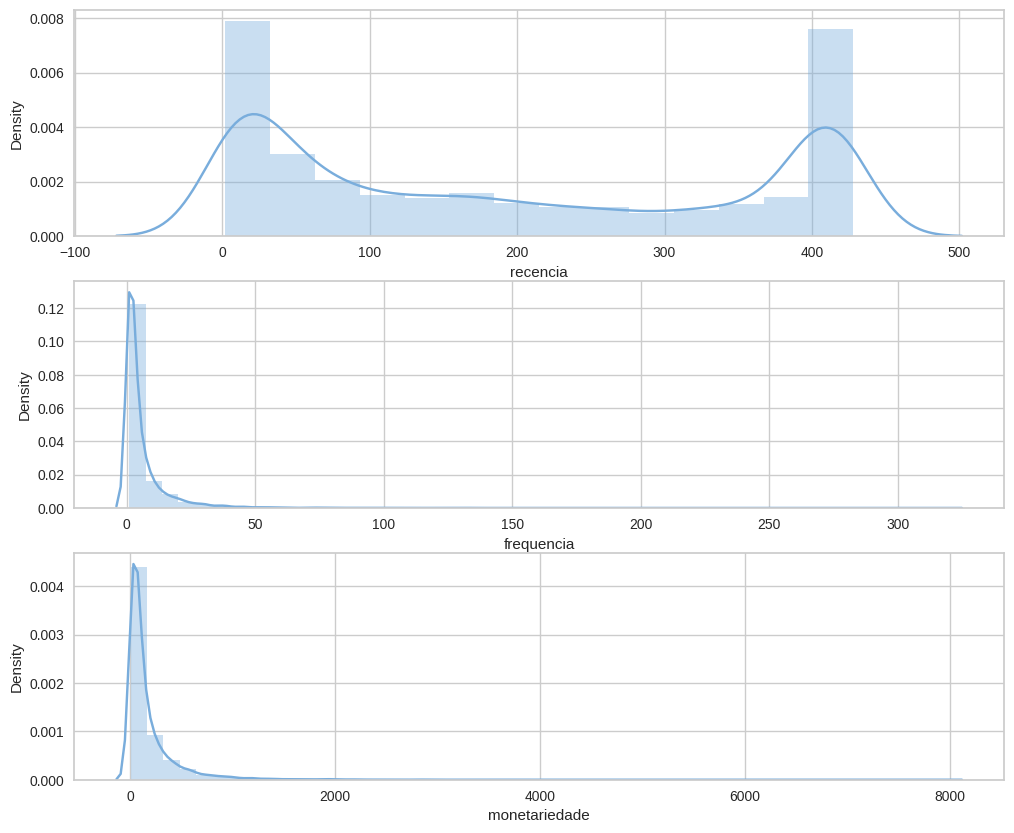

In [ ]:
plt.figure(figsize=(12,10))


plt.subplot(3, 1, 1); sns.distplot(rfm['recencia'])
plt.subplot(3, 1, 2); sns.distplot(rfm['frequencia'])
plt.subplot(3, 1, 3); sns.distplot(rfm['monetariedade'])

plt.show()

Como visto anteriormente, temos essa grande quantidade de recencia nos 400, pois são usuarios inativos, talvez com anos de registros. então não irei alterar essa parte.

Notamos que os dados estão desbalanceados e isso pode afetar a qualidade das análises. Para melhorar, vamos aplicar técnicas que deixem as distribuições mais simétricas.

**Vamos testar três tipos de transformações:**

**Logarítmica** – boa para variáveis com valores muito altos, pois reduz extremos.

**Raiz quadrada** – ajuda a corrigir assimetrias leves e suaviza a distribuição.

**Box-Cox**– ajusta os dados automaticamente para encontrar o formato mais equilibrado (funciona apenas com valores positivos).

✨ Com essas transformações, buscamos tornar os dados mais estáveis e fáceis de interpretar, aumentando a precisão dos resultados.

In [ ]:
from scipy import stats
def skewness(x):
    fig, ax = plt.subplots(2, 2, figsize=(5,5))
    sns.distplot(rfm[x], ax=ax[0,0])
    sns.distplot(np.log(rfm[x]), ax=ax[0,1])
    sns.distplot(np.sqrt(rfm[x]), ax=ax[1,0])
    sns.distplot(stats.boxcox(rfm[x])[0], ax=ax[1,1])
    plt.tight_layout()
    plt.show()

    print('Logarítmica : Coeficiente Skew de :', rfm[x].skew().round(2), 'to', np.log(rfm[x]).skew().round(2))
    print('Raiz Quadrada : Coeficiente Skew de :', rfm[x].skew().round(2), 'to', np.sqrt(rfm[x]).skew().round(2))
    print('Box-Cox  :  Coeficiente Skew de: ', rfm[x].skew().round(2), 'to', pd.Series(stats.boxcox(rfm[x])[0]).skew().round(2))

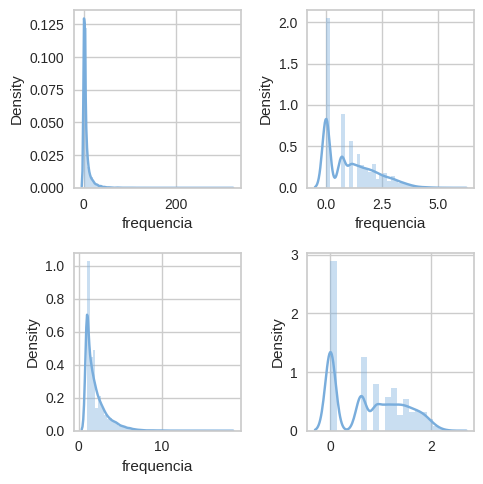

Logarítmica : Coeficiente Skew de : 7.39 to 0.71
Raiz Quadrada : Coeficiente Skew de : 7.39 to 2.25
Box-Cox  :  Coeficiente Skew de:  7.39 to 0.17


In [ ]:
skewness('frequencia')

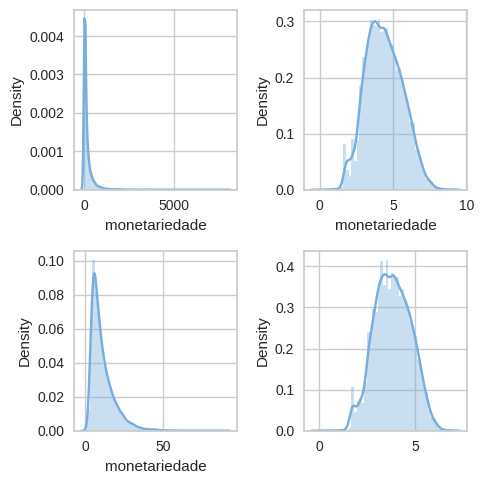

Logarítmica : Coeficiente Skew de : 6.65 to 0.19
Raiz Quadrada : Coeficiente Skew de : 6.65 to 1.95
Box-Cox  :  Coeficiente Skew de:  6.65 to 0.01


In [ ]:
skewness('monetariedade')

Os gráficos apresentados acima mostram que as variáveis transformadas com Box-Cox ficaram com uma distribuição mais simétrica em comparação com outras transformações.

Então vamos atualizar o RFM

In [ ]:
rfm_fixed = pd.DataFrame()
rfm_fixed['recencia'] = rfm['recencia']
rfm_fixed['frequencia'] = stats.boxcox(rfm['frequencia'])[0]
rfm_fixed['monetariedade'] = stats.boxcox(rfm['monetariedade'])[0]
rfm_fixed.tail()

,recencia,frequencia,monetariedade
21973,18,0.000000,2.959103
21975,189,1.087539,2.822066
21976,396,0.000000,3.570535
21978,284,0.000000,2.959103
21982,398,0.000000,1.706251


**Agora**, como as variáveis do nosso conjunto de dados possuem médias e variâncias diferentes, é necessário normalizá-las. Uma forma eficiente de fazer isso é utilizando o objeto **StandardScaler** da biblioteca **scikit-learn**.

Essa padronização torna as variáveis mais comparáveis entre si, facilitando análises e modelos que dependem de escalas consistentes.

In [ ]:
scaler =  StandardScaler()
scaler.fit(rfm_fixed)
rfm_normalizado = scaler.fit_transform(rfm_fixed)
print(rfm_normalizado.mean(axis=0).round(2))
print(rfm_normalizado.std(axis=0).round(2))

[-0. -0. -0.]
[1. 1. 1.]


As **médias** agora são iguais a zero e o desvio padrão é 1!
Sucesso absoluto! Tudo padronizado, pronto pra rodar os modelos com dados equilibrados e comparáveis. Bora pra próxima etapa! 🚀

In [ ]:
rfm_normalizado

array([[-0.84608713, -1.16064686, -0.58550618],
       [-0.22306588,  1.51036889,  1.60313604],
       [-1.10775605, -1.16064686, -1.1890124 ],
       ...,
       [ 1.24103406, -1.16064686, -0.2590594 ],
       [ 0.54325026, -1.16064686, -0.91269538],
       [ 1.25349448, -1.16064686, -2.25202617]])

In [ ]:
nome_colunas = ['recencia', 'frequencia', 'monetariedade']

rfm_normalizado_df = pd.DataFrame(rfm_normalizado, columns=nome_colunas)

In [ ]:
rfm_normalizado_df

,recencia,frequencia,monetariedade
0,-0.846087,-1.160647,-0.585506
1,-0.223066,1.510369,1.603136
2,-1.107756,-1.160647,-1.189012
3,-1.188749,1.510369,1.551900
4,-0.889699,-0.253646,0.339978
...,...,...,...
11958,-1.113986,-1.160647,-0.912695
11959,-0.048620,0.450332,-1.059191
11960,1.241034,-1.160647,-0.259059
11961,0.543250,-1.160647,-0.912695


<Axes: xlabel='recencia', ylabel='Density'>

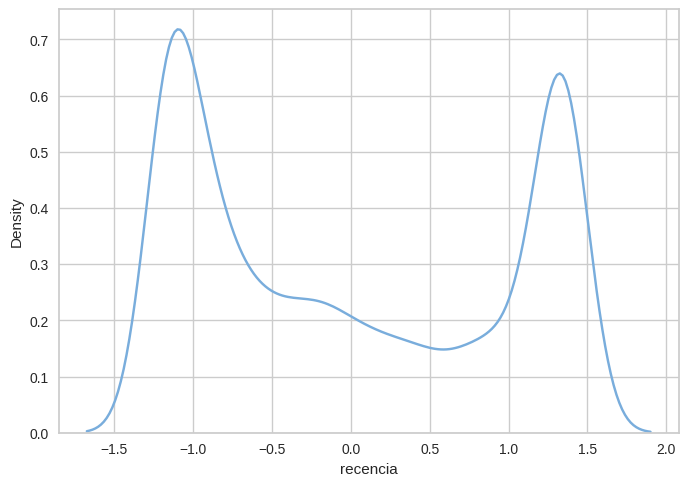

In [ ]:
sns.kdeplot(data=rfm_normalizado_df, x="recencia")


## 🌍 K-Means para o Clustering

Precisamos definir qual hiperparâmetro se ajusta melhor aos nossos dados para que o clustering atinja sua melhor performance. Para isso, estamos utilizando o **método do cotovelo (elbow method)**, que nos ajuda a identificar o número ideal de clusters para o nosso modelo e conjunto de dados.

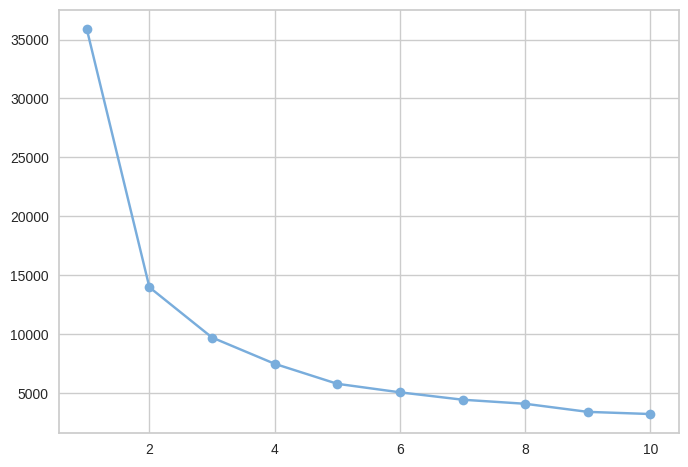

In [ ]:
n_clusters = range(1, 11)
cluster_sse = []
for i in n_clusters:
    kmeans = KMeans(n_clusters= i)
    kmeans.fit(rfm_normalizado_df)
    cluster_sse.append(kmeans.inertia_)

plt.plot(n_clusters, cluster_sse, marker = "o")
plt.show()

In [ ]:
# Definimos o intervalo de valores de K (número de clusters) que vamos testar
K = range(1, 20)  # Testamos de 1 até 19 clusters

# Listas e dicionários para armazenar métricas para cada K
distortions = []  # Armazena a média das menores distâncias de cada ponto ao seu centroide (distortion)
inertias = []     # Armazena os valores de inércia (SSE) para cada K
mapping1 = {}     # Mapeia o valor de K para seu respectivo valor de distortion
sse = {}          # Mapeia o valor de K para seu respectivo valor de inércia (SSE)

# Loop para testar o KMeans com diferentes valores de K
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)  # Inicializa o modelo KMeans com K clusters
    kmeans.fit(rfm_normalizado_df)  # Treina o modelo nos dados normalizados

    # Calcula a distortion: média das menores distâncias de cada ponto ao centroide mais próximo
    distortions.append(
        sum(np.min(cdist(rfm_normalizado_df, kmeans.cluster_centers_, 'euclidean'), axis=1))
        / rfm_normalizado_df.shape[0]
    )

    # Armazena a inércia (SSE) fornecida pelo modelo
    inertias.append(kmeans.inertia_)

    # Salva os valores em dicionários para facilitar análises futuras
    mapping1[k] = distortions[-1]  # Distortion para o valor atual de K
    sse[k] = kmeans.inertia_       # SSE (inércia) para o valor atual de K

# Imprime os valores de distortion para cada K testado
for key, val in mapping1.items():
    print(f'{key} : {val}')


1 : 1.6130285675280287
2 : 0.9928644234943509
3 : 0.8081877174182167
4 : 0.713982996825115
5 : 0.6261648964817358
6 : 0.5845772612735084
7 : 0.537968063726814
8 : 0.4995860676866076
9 : 0.4772307625337617
10 : 0.45648721949320625
11 : 0.4381734371159167
12 : 0.4257759253438157
13 : 0.41394003652096006
14 : 0.4060291723950213
15 : 0.39344579525706463
16 : 0.3870734353934807
17 : 0.36673392659405624
18 : 0.3598867690876346
19 : 0.35167268630793214


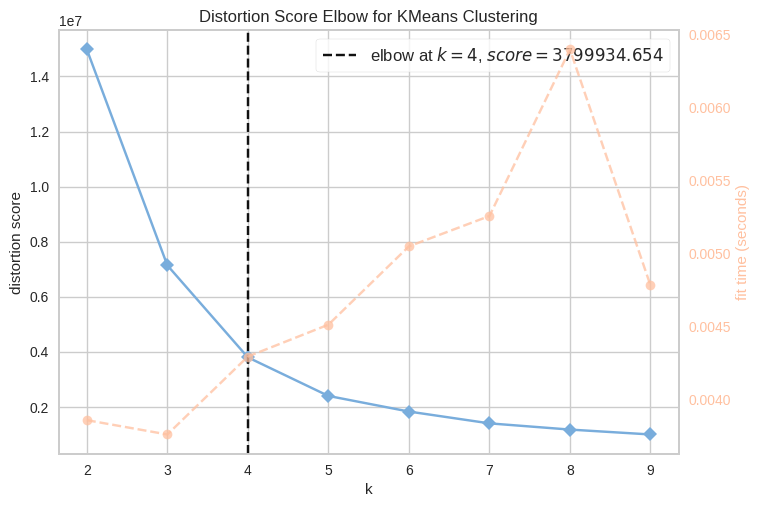

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=9, random_state=42), k=(2, 10))

In [ ]:
X, y = load_nfl()

# Use the quick method and immediately show the figure
kelbow_visualizer(KMeans(random_state=42), X, k=(2,10))

**Então vamos usar k = 4**

 **K=4**

In [ ]:
model = KMeans(n_clusters=4, random_state=42)
model.fit(rfm_normalizado_df)
model.labels_.shape

rfm["cluster"] = model.labels_
rfm.head()
rfm.groupby('cluster').agg({
    'recencia':'mean',
    'frequencia':'mean',
    'monetariedade':['mean', 'count']}).round(1)

recencia frequencia monetariedade      
            mean       mean          mean count
cluster                                        
0          389.6        1.1          30.9  3486
1           48.7       14.3         411.5  3992
2           85.1        2.0          51.5  2363
3          283.2        3.7         112.7  2122

Com base nas tabelas acima, podemos comparar a distribuição das médias das métricas de recência, **frequência e monetáriedade** entre os agrupamentos com  4 clusters.

Criando d**ataframe fimal**, com as 3 segmentações, grupo pricipal, subgrupo, e clusters.

In [ ]:
# Seleciona apenas as colunas que você quer trazer do rfm (evita duplicar as métricas RFM brutas)
rfm_extra = rfm[['user_id', 'recencia_score', 'frequencia_score', 'monetariedade_score',
                 'rfm_score', 'segmento', 'categoria_rfm', 'cluster']]

# Faz o merge com base na coluna 'user_id' de ambos os DataFrames
df_final = df.merge(rfm_extra, how='left', on='user_id')

# Exibe as primeiras linhas do DataFrame final
df_final


,registration_date,registration_country,purchase_count,purchase_count_delivery,purchase_count_takeaway,first_purchase_day,last_purchase_day,user_id,breakfast_purchases,lunch_purchases,...,recencia,frequencia,monetariedade,recencia_score,frequencia_score,monetariedade_score,rfm_score,segmento,categoria_rfm,cluster
0,2019-09-01,FIN,1,1.0,0.0,2020-09-02,2020-09-02,2,0.0,1.0,...,61,1,38.456,4,1,2,41,promissores,otimos_clientes,2
1,2019-09-01,DNK,19,19.0,0.0,2019-12-10,2020-05-25,3,0.0,4.0,...,161,19,631.488,3,5,5,35,parceiros_longa_data,otimos_clientes,1
2,2019-09-01,FIN,1,1.0,0.0,2020-10-14,2020-10-14,8,0.0,0.0,...,19,1,19.228,5,1,1,51,recem_chegados,otimos_clientes,2
3,2019-09-01,FIN,19,19.0,0.0,2020-04-18,2020-10-27,13,0.0,8.0,...,6,19,587.972,5,5,5,55,aliados_ouro,otimos_clientes,1
4,2019-09-01,FIN,2,2.0,0.0,2020-08-21,2020-09-09,14,0.0,1.0,...,54,2,118.404,4,2,4,42,quase_fieis,otimos_clientes,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11958,2019-09-30,FIN,1,1.0,0.0,2020-10-15,2020-10-15,21974,0.0,0.0,...,18,1,26.312,5,2,1,52,quase_fieis,otimos_clientes,2
11959,2019-09-30,GRC,4,4.0,0.0,2020-04-11,2020-04-27,21976,2.0,2.0,...,189,4,22.264,3,4,1,34,parceiros_longa_data,otimos_clientes,2
11960,2019-09-30,DNK,1,1.0,0.0,2019-10-03,2019-10-03,21977,0.0,0.0,...,396,1,56.672,2,2,3,22,adormecidos,inativos,0
11961,2019-09-30,GRC,1,1.0,0.0,2020-01-23,2020-01-23,21979,0.0,0.0,...,284,1,26.312,2,2,1,22,adormecidos,inativos,0


In [ ]:
df_final.to_csv('df_final_rfm.csv', index=False)

In [ ]:
caminho = '/content/df_final_rfm.csv'
df_final = pd.read_csv(caminho)

Kpis e dfs para visualização

In [ ]:
otimos_clientes = df_final['categoria_rfm'].value_counts().get('otimos_clientes', 0)
clientes_em_risco = df_final['categoria_rfm'].value_counts().get('em_risco', 0)
clientes_inativos = df_final['categoria_rfm'].value_counts().get('inativos', 0)


media_recencia = round(df_final['recencia'].mean(), 1)
media_frequencia = round(df_final['frequencia'].mean(), 1)
media_monetariedade = round(df_final['monetariedade'].mean(), 1)

total_clientes = len(df_final)

print(f"Ótimos clientes: {otimos_clientes}")
print(f"Clientes em risco: {clientes_em_risco}")
print(f"Clientes inativos: {clientes_inativos}")
print("--------------------------------------------")
print(f"Média de Recência: {media_recencia}")
print(f"Média de Frequência: {media_frequencia}")
print(f"Média de Monetariedade: {media_monetariedade}")




Ótimos clientes: 5735
Clientes em risco: 2076
Clientes inativos: 4152
--------------------------------------------
Média de Recência: 196.8
Média de Frequência: 6.1
Média de Monetariedade: 176.5


In [ ]:
total_clientes

10346

In [ ]:
vizu_df = pd.DataFrame(columns=['segmento', 'total_clientes', 'total_transacao', 'media_pedidos_clientes', 'media_transacao_clientes', 'media_monetariedade_clientes'])

for segmento in df_final['segmento'].unique():
    segmento_df = df_final[df_final['segmento'] == segmento]
    total_clientes = len(segmento_df)
    total_transacao = segmento_df['total_purchases_eur'].sum()
    media_pedidos_clientes = segmento_df['purchase_count'].mean()
    media_transacao_clientes = segmento_df['total_purchases_eur'].mean()
    media_monetariedade_clientes = total_transacao / total_clientes if total_clientes > 0 else 0

    vizu_df = pd.concat([vizu_df, pd.DataFrame({
        'segmento': [segmento],
        'total_clientes': [total_clientes],
        'total_transacao': [total_transacao],
        'media_pedidos_clientes': [media_pedidos_clientes],
        'media_transacao_clientes': [media_transacao_clientes],
        'media_monetariedade_clientes': [media_monetariedade_clientes]
    })], ignore_index=True)

# Arredondar as colunas numéricas para 1 casa decimal
numeric_cols = ['total_transacao', 'media_pedidos_clientes', 'media_transacao_clientes', 'media_monetariedade_clientes']
vizu_df[numeric_cols] = vizu_df[numeric_cols].round(1)

# Ordenar o DataFrame pela coluna 'total_clientes' em ordem decrescente
vizu_df = vizu_df.sort_values(by='total_clientes', ascending=False)
vizu_df



,segmento,total_clientes,total_transacao,media_pedidos_clientes,media_transacao_clientes,media_monetariedade_clientes
8,adormecidos,3416,118317.0,1.1,34.6,34.6
1,parceiros_longa_data,2402,755348.7,10.8,314.5,314.5
3,aliados_ouro,1908,884945.4,16.6,463.8,463.8
7,em_risco,1225,116434.6,3.2,95.0,95.0
4,quase_fieis,1158,82196.7,2.3,71.0,71.0
5,quase_inativos,736,29287.3,1.2,39.8,39.8
6,precisam_de_carinho,715,61753.3,2.6,86.4,86.4
0,promissores,175,5487.1,1.0,31.4,31.4
9,nao_podemos_perder,136,55152.0,17.9,405.5,405.5
2,recem_chegados,92,2373.1,1.0,25.8,25.8


In [ ]:
total_clientes

11963

Full dash code

Testando grafico com tabela explicativa de clsuter

In [ ]:
# -*- coding: utf-8 -*-
import dash
import dash_bootstrap_components as dbc
from dash import dcc, html, dash_table, ctx
from dash.dependencies import Input, Output, State
import plotly.express as px
import plotly.io as pio
import pandas as pd
import numpy as np # Import numpy for example data


df_final['segmento'] = df_final['segmento'].astype(str)
df_final['cluster'] = df_final['cluster'].astype(str) # Garante que cluster é string

# =================== TEMA E ESTILO ===================
pio.templates.default = "simple_white"
cores_segmento = {
    'adormecidos': '#636EFA', 'em_risco': '#EF553B', 'quase_inativos': '#AB63FA',
    'aliados_ouro': '#00CC96', 'nao_podemos_perder': '#FFA15A', 'parceiros_longa_data': '#19D3F3',
    'precisam_de_carinho': '#FF6692', 'quase_fieis': '#B6E880', 'promissores': '#FECB52',
    'recem_chegados': '#FF97FF',
    'default': '#CCCCCC' # Cor padrão para segmentos não mapeados
}
cores_cluster = {
    "0": "#636EFA", "1": "#EF553B", "2": "#00CC96", "3": "#FFA15A"
}

# --- MUDANÇA DE FONTE E ÍCONES ---
external_styles = [
    dbc.themes.BOOTSTRAP,
    "https://fonts.googleapis.com/css2?family=Poppins:wght@400;600;700&display=swap",
    "https://cdn.jsdelivr.net/npm/bootstrap-icons@1.10.5/font/bootstrap-icons.css"
]

# =================== CÁLCULOS E AGRUPAMENTOS ===================
df_final['segmento'] = df_final['segmento'].astype(str)
df_group = df_final.groupby('segmento').agg(
    avg_recencia=('recencia', 'mean'),
    avg_frequencia=('frequencia', 'mean'),
    avg_monetariedade=('monetariedade', 'mean'),
    total_count=('user_id', 'count')
).reset_index()

# Certifica que o cluster é tratado como string para agrupamento e mapeamento de cores
df_final['cluster'] = df_final['cluster'].astype(str)
df_group_cluster = df_final.groupby('cluster').agg(
    avg_recencia=('recencia', 'mean'),
    avg_frequencia=('frequencia', 'mean'),
    avg_monetariedade=('monetariedade', 'mean'),
    total_count=('user_id', 'count')
).reset_index()
# =================== GRÁFICOS ===================
default_font = dict(family='Poppins', size=13)

# Garantir que todas as cores de segmento existem no mapa ou usar default
cores_segmento_map = {seg: cores_segmento.get(seg, cores_segmento['default']) for seg in df_group['segmento'].unique()}

fig_bubble_rf_seg = px.scatter(
    df_group, x='avg_recencia', y='avg_frequencia', size='total_count',
    color='segmento', color_discrete_map=cores_segmento_map, size_max=60,
    labels={'avg_recencia': 'Média Recência (dias)', 'avg_frequencia': 'Média Frequência'},
    render_mode='webgl'
)
fig_bubble_rf_seg.update_traces(marker=dict(line=dict(width=1, color='DarkSlateGrey')))
fig_bubble_rf_seg.update_layout(
    plot_bgcolor='#fdfdfd', paper_bgcolor='#fafafa', margin=dict(t=50, l=10, r=10, b=10),
    title={
        'text': "Recência x Frequência (Segmentos)", 'x': 0.5, 'xanchor': 'center',
        'font': {'size': 20, 'color': '#333', 'family': 'Poppins'}
    },
    font=default_font,
    legend=dict(title=None, orientation="v", x=1.02, y=1, xanchor='left', bgcolor='rgba(0,0,0,0)')
)
fig_bubble_fm_seg = px.scatter(
    df_group, x='avg_frequencia', y='avg_monetariedade', size='total_count',
    color='segmento', color_discrete_map=cores_segmento_map, size_max=60,
    labels={'avg_frequencia': 'Média Frequência', 'avg_monetariedade': 'Média Monetariedade (R$)'},
    render_mode='webgl'
)
fig_bubble_fm_seg.update_traces(marker=dict(line=dict(width=1, color='DarkSlateGrey')))
fig_bubble_fm_seg.update_layout(
    plot_bgcolor='#fdfdfd', paper_bgcolor='#fafafa', margin=dict(t=50, l=10, r=10, b=10),
    title={
        'text': "Monetariedade x Frequência (Segmentos)", 'x': 0.5, 'xanchor': 'center',
        'font': {'size': 20, 'color': '#333', 'family': 'Poppins'}
    },
    font=default_font,
    legend=dict(title=None, orientation="v", x=1.02, y=1, xanchor='left', bgcolor='rgba(0,0,0,0)')
)

default_font_cluster = dict(family='Poppins', size=13, color='black')
fig_cluster_rf = px.scatter(
    df_group_cluster,
    x='avg_recencia', y='avg_frequencia', size='total_count',
    color='cluster', color_discrete_map=cores_cluster,
    labels={'avg_recencia': 'Média Recência (dias)', 'avg_frequencia': 'Média Frequência'},
    size_max=60, render_mode='webgl'
)
fig_cluster_rf.update_traces(marker=dict(symbol='circle', line=dict(width=1, color='black')))
fig_cluster_rf.update_layout(
    title={'text': "Recência x Frequência por Cluster", 'x': 0.5, 'xanchor': 'center',
           'font': {'size': 20, 'color': 'black', 'family': 'Poppins'}},
    font=default_font_cluster, plot_bgcolor='#ffffff', paper_bgcolor='#ffffff', legend=dict(title=None)
)
fig_cluster_fm = px.scatter(
    df_group_cluster,
    x='avg_frequencia', y='avg_monetariedade', size='total_count',
    color='cluster', color_discrete_map=cores_cluster,
    labels={'avg_frequencia': 'Média Frequência', 'avg_monetariedade': 'Média Monetariedade (R$)'},
    size_max=60, render_mode='webgl'
)
fig_cluster_fm.update_traces(marker=dict(symbol='circle', line=dict(width=1, color='black')))
fig_cluster_fm.update_layout(
    title={'text': "Monetariedade x Frequência por Cluster", 'x': 0.5, 'xanchor': 'center',
           'font': {'size': 20, 'color': 'black', 'family': 'Poppins'}},
    font=default_font_cluster, plot_bgcolor='#ffffff', paper_bgcolor='#ffffff', legend=dict(title=None)
)

# =================== CARDS (Com Estética Melhorada) ===================
def criar_card(titulo, valor, emoji, cor="#ffffff"):
    card_title = f"{emoji} {titulo}" if emoji else titulo
    # Formatando o valor para inteiro, se possível
    try:
        valor_formatado = f"{int(valor):,}".replace(",", ".")
    except (ValueError, TypeError):
        valor_formatado = str(valor) # Mantém como string se não for numérico

    return dbc.Card(
        dbc.CardBody([
            html.H5(card_title, className="card-title", style={
                'fontFamily': 'Poppins',
                'fontWeight': '600',
                'fontSize': '0.95rem',
                'color': '#555'
            }),
            html.H2(valor_formatado, className="card-text", style={
                'fontFamily': 'Poppins',
                'fontWeight': '700',
                'fontSize': '2rem',
                'color': '#222'
            })
        ]),
        className="mb-2 text-center shadow-sm p-3 rounded h-100",
        style={"background": f"linear-gradient(to right, {cor}, #ffffff)", 'border': 'none'}
    )

def card_media(indicador, letra, cor_letra, valor):
    formatted_valor = f"{valor:,.2f}".replace(",", "X").replace(".", ",").replace("X", ".") # Formato brasileiro
    return dbc.Card(
        dbc.CardBody([
            html.Div([
                html.Div(letra, style={
                    "fontSize": "2.5em", "color": cor_letra, "marginRight": "15px",
                    "border": f"2px solid {cor_letra}", "borderRadius": "50%",
                    "width": "60px", "height": "60px", "display": "flex",
                    "alignItems": "center", "justifyContent": "center", "flexShrink": 0,
                    'fontWeight': '700', 'fontFamily': 'Poppins'
                }),
                html.Div([
                    html.H4(f"{indicador}", className="card-title mb-1", style={
                        'fontFamily': 'Poppins',
                        'fontWeight': '600',
                        'fontSize': '1rem',
                        'color': '#444'
                    }),
                    html.H2(formatted_valor, className="card-text", style={
                        'fontFamily': 'Poppins',
                        'fontWeight': '700',
                        'fontSize': '1.8rem',
                        'color': '#222'
                    })
                ], style={"textAlign": "left", "margin": "auto 0"}) # Alinhado à esquerda
            ], style={"display": "flex", "alignItems": "center", "justifyContent": "flex-start"}) # Conteúdo alinhado à esquerda
        ]),
        className="mb-2 shadow-sm p-3 rounded h-100",
        style={"backgroundColor": "#f8f9fa", 'border': 'none'}
    )

# =================== DEFINIÇÃO DOS CARDS ===================
card_total_usuarios = criar_card("Total de Usuários", total_usuarios, "", "#e3f2fd")
card_total_clientes = criar_card("Total de Clientes", total_clientes, "", "#e8f5e9")
card_otimos_clientes = criar_card("Ótimos Clientes", otimos_clientes, "🌟", "#fff8e1")
card_clientes_em_risco = criar_card("Clientes em Risco", clientes_em_risco, "⚠️", "#ffebee")
card_clientes_inativos = criar_card("Clientes Inativos", clientes_inativos, "☁️", "#ede7f6")
card_media_recencia = card_media("Recência Média", "R", "#dc3545", media_recencia)
card_media_frequencia = card_media("Frequência Média", "F", "#0d6efd", media_frequencia)
card_media_monetariedade = card_media("Monetariedade Média", "M", "#198754", media_monetariedade)

# =================== TABELA EXPLICATIVA CLUSTER (NOVO) ===================
tabela_cluster_explicativa_data = [
    {'Cluster': '0', '% Clientes': '29.1%', 'Top Segmentos': 'Adormecidos (91.9%), Em Risco (4.7%), Quase Inativos (3.4%)', 'Perfil': 'Clientes com 1 compra, gasto baixo, inativos há muito tempo.'},
    {'Cluster': '1', '% Clientes': '33.4%', 'Top Segmentos': 'Parceiros Longa Data (49.0%), Aliados Ouro (46.6%), Quase Fiéis (2.8%)', 'Perfil': 'Clientes muito frequentes, recentes e de alto valor. Valiosos e ativos.'},
    {'Cluster': '2', '% Clientes': '19.8%', 'Top Segmentos': 'Quase Fiéis (44.4%), Quase Inativos (24.0%), Precisam de Carinho (13.7%)', 'Perfil': 'Gasto moderado, baixa frequência, inativos há algum tempo. Potencial de lealdade.'},
    {'Cluster': '3', '% Clientes': '17.7%', 'Top Segmentos': 'Em Risco (49.8%), Precisam de Carinho (17.7%), Parceiros Longa Data (15.8%)', 'Perfil': 'Grandes compras passadas, inativos há tempo, frequência diminuiu. Risco de churn.'}
]

tabela_cluster_explicativa_columns = [
    {"name": "Cluster", "id": "Cluster"},
    {"name": "% Clientes", "id": "% Clientes"},
    {"name": "Principais Segmentos RFM", "id": "Top Segmentos"}, # Nome da coluna atualizado
    {"name": "Perfil Resumido", "id": "Perfil"} # Nome da coluna atualizado
]

tabela_explicativa_cluster = dash_table.DataTable(
    id='tabela-explicativa-cluster',
    columns=tabela_cluster_explicativa_columns,
    data=tabela_cluster_explicativa_data,
    style_table={'overflowX': 'auto', 'marginBottom': '30px', 'border': '1px solid #ddd', 'borderRadius': '5px'},
    style_cell={
        'textAlign': 'left', 'padding': '10px',
        'fontFamily': 'Poppins', 'fontSize': '0.85rem',
        'border': '1px solid #eee',
        'whiteSpace': 'normal', 'height': 'auto', # Permite quebra de linha
        'minWidth': '100px', 'width': 'auto', 'maxWidth': '350px' # Ajuste de largura
    },
    style_header={
        'backgroundColor': '#f0f2f5', 'fontWeight': 'bold',
        'fontFamily': 'Poppins', 'fontSize': '0.9rem',
        'border': '1px solid #ddd',
        'color': '#333'
    },
    style_data_conditional=[
        {'if': {'row_index': 'odd'}, 'backgroundColor': '#fdfdfd'},
        {'if': {'column_id': 'Cluster'}, 'textAlign': 'center', 'fontWeight': 'bold'}, # Centraliza Cluster ID
        {'if': {'column_id': '% Clientes'}, 'textAlign': 'center'}, # Centraliza %
    ],
    style_as_list_view=True, # Remove linhas verticais entre células de dados
)

# =================== APP DASH ===================
app = dash.Dash(__name__, external_stylesheets=external_styles, suppress_callback_exceptions=True)
app.title = "Segmentação e Cluster RFM"

# ========= LAYOUT FIXO (CABEÇALHO E KPIS) =========
header_layout = dbc.Container([
    # Título principal
    dbc.Row(
        dbc.Col(html.H1("Análise RFM", className="text-center my-4", style={
            'fontFamily': 'Poppins',
            'fontWeight': '700',
            'color': '#333',
            'letterSpacing': '1px'
        }))
    ),
    # Cards
    dbc.Row([
        dbc.Col(card_total_usuarios, md=2),
        dbc.Col(card_total_clientes, md=2),
        dbc.Col(card_otimos_clientes, md=2),
        dbc.Col(card_clientes_em_risco, md=3),
        dbc.Col(card_clientes_inativos, md=3)
    ], className="mb-4 g-4", align="stretch"),
    dbc.Row([
        dbc.Col(card_media_recencia, md=4),
        dbc.Col(card_media_frequencia, md=4),
        dbc.Col(card_media_monetariedade, md=4)
    ], className="mb-4 g-4", align="stretch"),
], fluid=True, style={"background": "linear-gradient(to bottom, #f0f2f5, #ffffff)", "padding": "20px"})

# ========= LAYOUT DINÂMICO (SEGMENTOS OU CLUSTERS) =========
# Define os layouts como variáveis para reutilização
segmentos_layout = html.Div([
    dbc.Row([
        dbc.Col(dcc.Graph(id='seg-fig-bubble-rf', figure=fig_bubble_rf_seg), md=6),
        dbc.Col(dcc.Graph(id='seg-fig-bubble-fm', figure=fig_bubble_fm_seg), md=6)
    ], className="mb-4"),
    # Dropdown, botão de download e tabela
    dbc.Row([
        dbc.Col([
            html.H4("Clientes por Segmento", className="text-center mb-3", style={
                'fontFamily': 'Poppins', 'fontWeight': '600'
            }),
            dcc.Dropdown(
                id='seg-segmento-dropdown',
                options=[{'label': seg.replace("_", " ").title(), 'value': seg} for seg in sorted(df_final['segmento'].unique())],
                value=sorted(df_final['segmento'].unique())[0] if df_final['segmento'].nunique() > 0 else None, # Valor inicial seguro
                clearable=False,
                placeholder="Selecione um segmento...",
                style={'marginBottom': '20px', 'fontFamily': 'Poppins'}
            ),
            html.Div([
                html.Button([
                    html.I(className="bi bi-download me-2"), "Baixar CSV"
                ], id="seg-btn-download-csv", n_clicks=0, className="btn btn-outline-primary mb-3", style={
                    'fontFamily': 'Poppins', 'fontWeight': '600'
                }),
                dcc.Download(id="seg-download-clientes-csv")
            ], style={'textAlign': 'left'}),
            dash_table.DataTable(
                id='seg-tabela-clientes-segmento',
                # Definir colunas aqui ajuda a pegá-las nos callbacks
                columns=[{"name": col.replace("_", " ").title(), "id": col} for col in df_final.columns if col not in ['cluster']], # Oculta cluster aqui
                page_size=10,
                page_current=0,
                page_action='native',
                filter_action='none',
                sort_action='native',
                style_table={'overflowX': 'auto', 'margin': 'auto', 'width': '100%'},
                style_cell={
                    'textAlign': 'center', 'minWidth': '100px', 'padding': '10px',
                    'border': '1px solid #dee2e6',
                    'fontFamily': 'Poppins',
                    'whiteSpace': 'normal', 'height': 'auto'
                },
                style_data_conditional=[
                    {'if': {'row_index': 'odd'}, 'backgroundColor': '#f8f9fa'},
                    {'if': {'column_id': 'segmento'}, 'fontWeight': 'bold', 'color': '#007bff'}
                ],
                style_header={
                    'backgroundColor': '#e9ecef', 'fontWeight': 'bold',
                    'fontFamily': 'Poppins',
                    'border': '1px solid #dee2e6'
                },
                style_as_list_view=True
            )
        ], width=12, className="mx-auto")
    ], className="my-4")
])

clusters_layout = html.Div([
    # Título para a tabela explicativa (NOVO)
    html.H4("Entendendo os Clusters", className="text-center mt-4 mb-3", style={ # Adicionado mt-4
         'fontFamily': 'Poppins', 'fontWeight': '600', 'color': '#444'
    }),
    # Tabela Explicativa de Clusters (NOVO)
    dbc.Row(
        dbc.Col(tabela_explicativa_cluster, width=12), # Largura 12 para ocupar a linha
        className="mb-4" # Espaçamento abaixo da tabela
    ),
    # Gráficos de Cluster (EXISTENTES)
    dbc.Row([
        dbc.Col(dcc.Graph(id='clu-fig-cluster-rf', figure=fig_cluster_rf), md=6),
        dbc.Col(dcc.Graph(id='clu-fig-cluster-fm', figure=fig_cluster_fm), md=6)
    ]),
    # Dropdown, botão de download e tabela de dados (EXISTENTES)
    dbc.Row([
        dbc.Col([
            html.H4("Clientes por Cluster", className="text-center mb-3 mt-4", style={ # Adicionado mt-4
                'fontFamily': 'Poppins', 'fontWeight': '600'
            }),
            dcc.Dropdown(
                id='clu-cluster-dropdown',
                options=[{'label': f'Cluster {str(c)}', 'value': str(c)} for c in sorted(df_final['cluster'].unique())],
                value=sorted(df_final['cluster'].unique())[0] if df_final['cluster'].nunique() > 0 else None, # Valor inicial seguro
                clearable=False,
                placeholder="Selecione um cluster...",
                style={'marginBottom': '20px', 'fontFamily': 'Poppins'}
            ),
            html.Div([
                html.Button([
                    html.I(className="bi bi-download me-2"), "Baixar CSV"
                ], id="clu-btn-download-cluster-csv", n_clicks=0,
                    className="btn btn-outline-success mb-3", style={'fontFamily': 'Poppins'}), # Mudou cor do botão
                dcc.Download(id="clu-download-clientes-cluster-csv")
            ], style={'textAlign': 'left'}),
            dash_table.DataTable(
                id='clu-tabela-clientes-cluster',
                # Definir colunas aqui ajuda a pegá-las nos callbacks
                columns=[{"name": col.replace("_", " ").title(), "id": col} for col in df_final.columns if col not in ['segmento']], # Oculta segmento aqui
                page_size=10,
                page_current=0,
                page_action='native',
                filter_action='none',
                sort_action='native',
                style_table={'overflowX': 'auto', 'margin': 'auto', 'width': '100%'},
                style_cell={
                    'textAlign': 'center', 'minWidth': '100px', 'padding': '10px',
                    'border': '1px solid #dee2e6', 'fontFamily': 'Poppins',
                    'whiteSpace': 'normal', 'height': 'auto'
                },
                style_data_conditional=[
                    {'if': {'row_index': 'odd'}, 'backgroundColor': '#f8f9fa'},
                    # Colorir baseado no cluster usando o mapa de cores
                    *[ {'if': {'filter_query': f'{{cluster}} = "{clust}"', 'column_id': 'cluster'},
                       'backgroundColor': cores_cluster.get(str(clust), '#CCCCCC'), # Usa a cor do cluster
                       'color': 'white', # Texto branco para melhor contraste
                       'fontWeight': 'bold'}
                      for clust in cores_cluster]
                ],
                style_header={
                    'backgroundColor': '#f1f1f1', 'fontWeight': 'bold',
                    'fontFamily': 'Poppins', 'color': '#333',
                    'border': '1px solid #dee2e6'
                },
                style_as_list_view=True
            )
        ], width=12, className="mx-auto")
    ], className="my-4")
])

# ========= LAYOUT PRINCIPAL =========
app.layout = dbc.Container([
    header_layout,
    dbc.Row(
        dbc.Col(
            # Atualizado para usar dbc.ButtonGroup para melhor aparência
            dbc.ButtonGroup([
                dbc.Button("Mostrar Segmentos", id="show-segmentos-button", n_clicks=0, color="primary", outline=True, className="me-1"),
                dbc.Button("Mostrar Clusters", id="show-clusters-button", n_clicks=0, color="success", outline=True),
            ]),
            width={"size": "auto"}, # Ajusta a largura ao conteúdo
            className="d-flex justify-content-center mb-3" # Centraliza os botões
        )
    ),
    # Elemento oculto para armazenar o estado da visualização (segmentos ou clusters)
    dcc.Store(id='view-mode-store', data='segmentos'),
    # Conteúdo dinâmico será carregado aqui pelos callbacks
    html.Div(id='dynamic-content')
], fluid=True, style={'paddingBottom': '50px'}) # Adiciona padding inferior

# =================== CALLBACKS ===================

# Callback para alternar entre os layouts e atualizar o botão ativo
@app.callback(
    Output('dynamic-content', 'children', allow_duplicate=True), # Saída duplicada
    Output('show-segmentos-button', 'outline', allow_duplicate=True), # Saída duplicada
    Output('show-clusters-button', 'outline', allow_duplicate=True), # Saída duplicada
    Output('view-mode-store', 'data'),
    Input('show-segmentos-button', 'n_clicks'),
    Input('show-clusters-button', 'n_clicks'),
    State('view-mode-store', 'data'),
    prevent_initial_call=True # IMPEDE execução inicial por este callback
)
def toggle_content_and_buttons(seg_clicks, clu_clicks, current_mode):
    button_id = ctx.triggered_id
    if button_id == 'show-clusters-button' and current_mode != 'clusters':
        return clusters_layout, True, False, 'clusters' # Mostra Clusters, botão Cluster ativo
    elif button_id == 'show-segmentos-button' and current_mode != 'segmentos':
        return segmentos_layout, False, True, 'segmentos' # Mostra Segmentos, botão Segmento ativo

    # Se clicar no botão já ativo ou nenhum botão relevante foi clicado, retorna NoUpdate para evitar re-render desnecessário
    # Ou, se preferir sempre retornar o estado atual:
    if current_mode == 'clusters':
         return clusters_layout, True, False, 'clusters'
    else: # current_mode == 'segmentos'
         return segmentos_layout, False, True, 'segmentos'
    # return dash.no_update, dash.no_update, dash.no_update, dash.no_update


# Callback para carregar o layout inicial (AGORA COM prevent_initial_call='initial_duplicate')
@app.callback(
    Output('dynamic-content', 'children', allow_duplicate=True), # Saída duplicada
    Output('show-segmentos-button', 'outline', allow_duplicate=True), # Saída duplicada
    Output('show-clusters-button', 'outline', allow_duplicate=True), # Saída duplicada
    Input('view-mode-store', 'data'), # Dispara quando o app carrega (ou quando o store muda)
    prevent_initial_call='initial_duplicate' # <<< CORREÇÃO APLICADA AQUI
)
def load_initial_content(initial_mode):
     print(f"Loading initial content based on mode: {initial_mode}") # Debug
     if initial_mode == 'clusters':
        return clusters_layout, True, False
     else: # Default to segmentos
        return segmentos_layout, False, True

# --- Callbacks para as tabelas de dados e downloads (sem alterações necessárias aqui) ---

# Callback para atualizar tabela de segmentos
@app.callback(
    Output('seg-tabela-clientes-segmento', 'data'),
    Input('seg-segmento-dropdown', 'value'),
    # Adiciona State para pegar colunas da tabela
    State('seg-tabela-clientes-segmento', 'columns')
)
def atualizar_tabela_segmento(segmento_selecionado, table_columns):
    if not segmento_selecionado:
        # Se não houver seleção, tenta usar o primeiro segmento como padrão
        segmento_selecionado = sorted(df_final['segmento'].unique())[0] if df_final['segmento'].nunique() > 0 else None
        if not segmento_selecionado:
            return [] # Retorna vazio se não houver segmentos

    df_filtrado = df_final[df_final['segmento'] == segmento_selecionado]
    # Pega os IDs das colunas definidas na tabela
    cols_to_show = [col['id'] for col in table_columns]
    return df_filtrado[cols_to_show].to_dict('records')

# Callback para download CSV de segmentos
@app.callback(
    Output("seg-download-clientes-csv", "data"),
    Input("seg-btn-download-csv", "n_clicks"),
    State("seg-segmento-dropdown", "value"), # Usa State
    State('seg-tabela-clientes-segmento', 'columns'), # Pega colunas da tabela
    prevent_initial_call=True
)
def baixar_csv_segmento(n_clicks, segmento_selecionado, table_columns):
    if n_clicks > 0 and segmento_selecionado:
        df_filtrado = df_final[df_final['segmento'] == segmento_selecionado]
        # Usa as colunas visíveis na tabela para o CSV
        cols_to_show = [col['id'] for col in table_columns]
        return dcc.send_data_frame(df_filtrado[cols_to_show].to_csv, f"clientes_{segmento_selecionado}.csv", index=False, encoding='utf-8-sig') # Adiciona encoding

# Callback para atualizar tabela de clusters
@app.callback(
    Output('clu-tabela-clientes-cluster', 'data'),
    Input('clu-cluster-dropdown', 'value'),
    # Adiciona State para pegar colunas da tabela
    State('clu-tabela-clientes-cluster', 'columns')
)
def atualizar_tabela_cluster(cluster_selecionado, table_columns):
    if not cluster_selecionado:
        # Se não houver seleção, tenta usar o primeiro cluster como padrão
        cluster_selecionado = sorted(df_final['cluster'].unique())[0] if df_final['cluster'].nunique() > 0 else None
        if not cluster_selecionado:
             return [] # Retorna vazio se não houver clusters

    # Garante que estamos comparando strings
    df_filtrado = df_final[df_final['cluster'] == str(cluster_selecionado)]
    # Pega os IDs das colunas definidas na tabela
    cols_to_show = [col['id'] for col in table_columns]
    return df_filtrado[cols_to_show].to_dict('records')

# Callback para download CSV de clusters
@app.callback(
    Output("clu-download-clientes-cluster-csv", "data"),
    Input("clu-btn-download-cluster-csv", "n_clicks"),
    State("clu-cluster-dropdown", "value"), # Usa State
    State('clu-tabela-clientes-cluster', 'columns'), # Pega colunas da tabela
    prevent_initial_call=True
)
def baixar_csv_cluster(n_clicks, cluster_selecionado, table_columns):
    if n_clicks > 0 and cluster_selecionado:
        # Garante que estamos comparando strings
        df_filtrado = df_final[df_final['cluster'] == str(cluster_selecionado)]
        # Usa as colunas visíveis na tabela para o CSV
        cols_to_show = [col['id'] for col in table_columns]
        return dcc.send_data_frame(df_filtrado[cols_to_show].to_csv, f"clientes_cluster_{cluster_selecionado}.csv", index=False, encoding='utf-8-sig') # Adiciona encoding

# =================== RUN SERVER ===================
if __name__ == '__main__':
    app.run(debug=True)

<IPython.core.display.Javascript object>

In [ ]:
pip install dash dash_bootstrap_components dash_core_components

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.5/202.5 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 7.5 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: Flask
    Found existing installation: Flask 3.1.0
    Uninstalling Flask-3.1.0:
      Successfully uninstalled Flask-3.1.0


### Analisando os Clusters.



In [ ]:
# Agrupa o número de clientes por cluster
fig1 = df_final.groupby('cluster').agg({'user_id': 'count'}).reset_index()

# Renomeia a coluna para 'count'
fig1.rename(columns={'user_id': 'count'}, inplace=True)

# Calcula a porcentagem de cada cluster
fig1['percent'] = (fig1['count'] / fig1['count'].sum()) * 100
fig1['percent'] = fig1['percent'].round(1)

# Visualiza os dados agregados
fig1.head()


,cluster,count,percent
0,0,3486,29.1
1,1,3992,33.4
2,2,2363,19.8
3,3,2122,17.7


**Recency x Frequency por Clusters.**



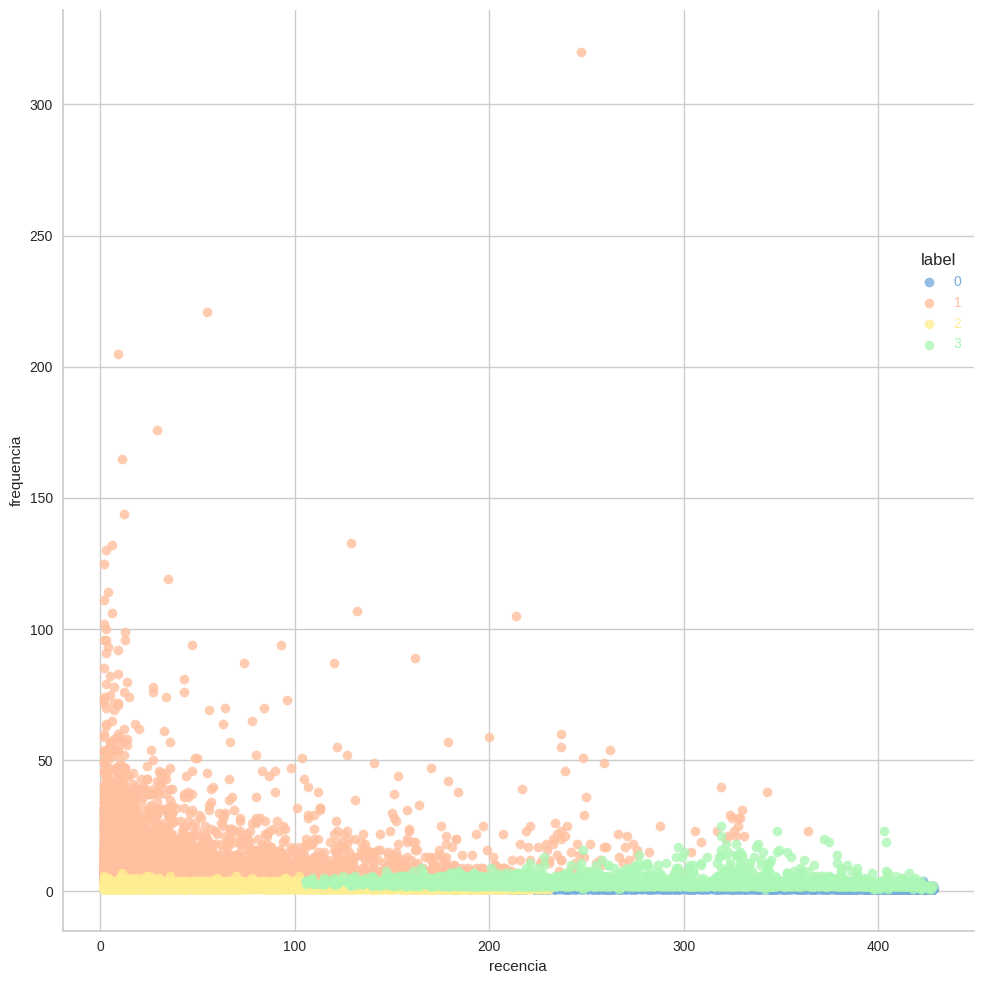

In [ ]:
data = pd.DataFrame(data=df_final,columns=['user_id','cluster','recencia','frequencia','monetariedade'])

facet = sns.lmplot(data=data, x='recencia', y='frequencia', hue='cluster', height=10,
                   fit_reg=False, legend=False)

#add a legend
leg = facet.ax.legend(bbox_to_anchor=[1, 0.75],
                         title="label", fancybox=True)
# change label colors
for i, text in enumerate(leg.get_texts()):
    plt.setp(text, color = customPalette[i])

**Monetary x Frequency por Clusters.**

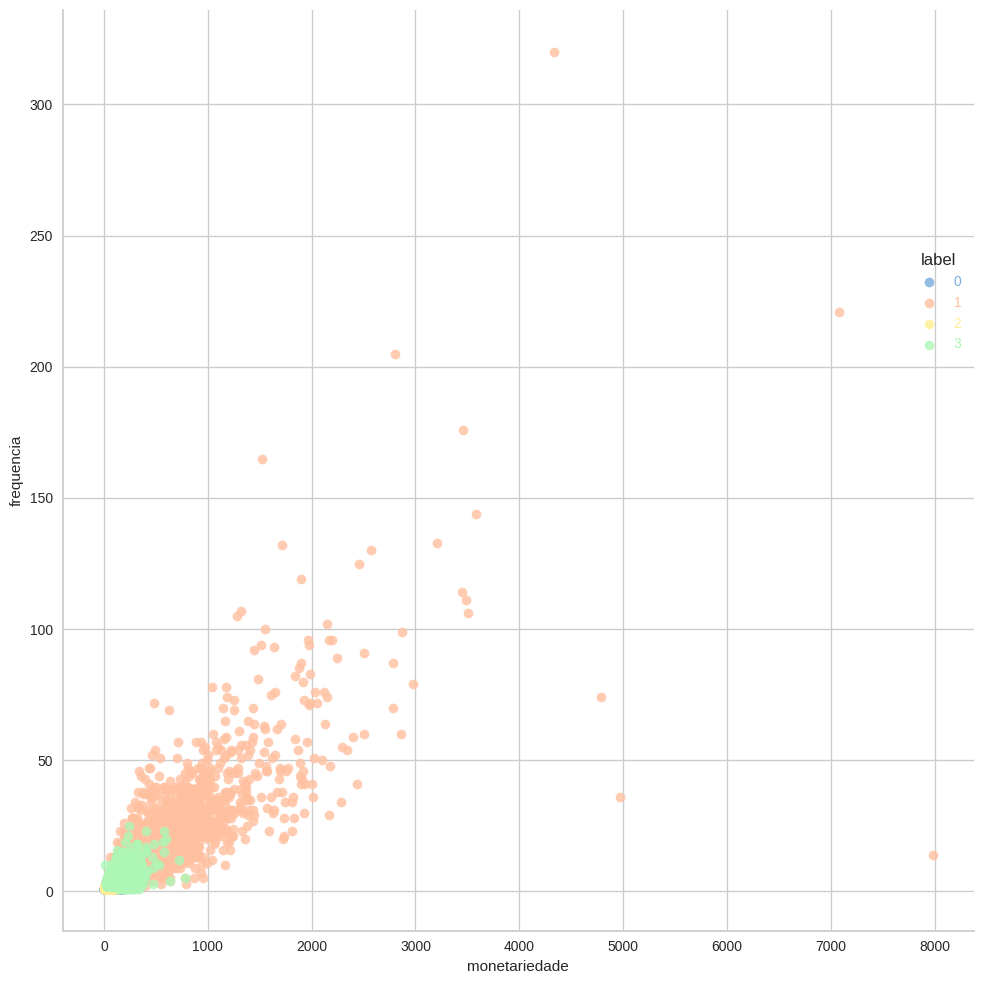

In [ ]:
# fig, ax = plt.subplots(figsize=(10, 8))
facet = sns.lmplot(data=data, x='monetariedade', y='frequencia', hue='cluster', height=10,
                   fit_reg=False, legend=False)


leg = facet.ax.legend(bbox_to_anchor=[1, 0.75],
                         title="label", fancybox=True)

for i, text in enumerate(leg.get_texts()):
    plt.setp(text, color = customPalette[i])

In [ ]:
import plotly.express as px
import plotly.io as pio

# Garante tema visual moderno
pio.templates.default = "plotly_dark"

fig = px.scatter_3d(
    df_final,
    x='recencia',
    y='frequencia',
    z='monetariedade',
    color='cluster',
    opacity=0.85,
    color_discrete_sequence=px.colors.qualitative.Set2,
    hover_data=['user_id'],  # Mostra user_id no hover, se disponível
    title='Distribuição 3D dos clientes por RFM e Cluster',
    labels={
        'recencia': 'Recência (dias)',
        'frequencia': 'Frequência (pedidos)',
        'monetariedade': 'Monetariedade (R$)',
        'cluster': 'Cluster'
    }
)

# Refinamento de layout e interação
fig.update_layout(
    scene=dict(
        xaxis_title='Recência (dias)',
        yaxis_title='Frequência',
        zaxis_title='Monetariedade (R$)',
        xaxis=dict(showgrid=True),
        yaxis=dict(showgrid=True),
        zaxis=dict(showgrid=True)
    ),
    margin=dict(l=0, r=0, b=0, t=40),
    legend_title='Cluster',
    height=700
)

fig.show()


In [ ]:
import dash
import dash_bootstrap_components as dbc
from dash import dcc, html
import plotly.express as px
import plotly.io as pio
import pandas as pd

# =================== TEMA E ESTILO ===================
pio.templates.default = "simple_white"

# Definindo cores para clusters (0 a 3)
cores_cluster = {
    "0": "#636EFA",
    "1": "#EF553B",
    "2": "#00CC96",
    "3": "#FFA15A"
}

# --- MUDANÇA DE FONTE E ÍCONES ---
external_styles = [
    dbc.themes.BOOTSTRAP,
    "https://fonts.googleapis.com/css2?family=Poppins:wght@400;600;700&display=swap",
    "https://cdn.jsdelivr.net/npm/bootstrap-icons@1.10.5/font/bootstrap-icons.css"
]

# =================== DADOS ===================
# Supondo que df_final já esteja carregado e contenha as colunas
# 'user_id', 'recencia', 'frequencia', 'monetariedade' e 'cluster'
# Converte o cluster para string para garantir que seja tratado como categoria
df_final['cluster'] = df_final['cluster'].astype(int).astype(str)

# Agrupar os dados por 'cluster'
df_group_cluster = df_final.groupby('cluster').agg(
    avg_recencia=('recencia', 'mean'),
    avg_frequencia=('frequencia', 'mean'),
    avg_monetariedade=('monetariedade', 'mean'),
    total_count=('user_id', 'count')
).reset_index()

# =================== GRÁFICOS ===================
default_font = dict(family='Poppins', size=13)

# Gráfico de bolhas: Recência x Frequência por Cluster
fig_cluster_rf = px.scatter(
    df_group_cluster,
    x='avg_recencia',
    y='avg_frequencia',
    size='total_count',
    color='cluster',
    color_discrete_map=cores_cluster,  # chaves agora em string
    size_max=60,
    labels={'avg_recencia': 'Média Recência (dias)', 'avg_frequencia': 'Média Frequência'},
    render_mode='webgl'
)
# Garante que os marcadores sejam círculos com borda definida
fig_cluster_rf.update_traces(marker=dict(symbol='circle', line=dict(width=1, color='DarkSlateGrey')))
fig_cluster_rf.update_layout(
    plot_bgcolor='#fdfdfd',
    paper_bgcolor='#fafafa',
    margin=dict(t=50, l=10, r=10, b=10),
    title={
        'text': "<b>Recência x Frequência por Cluster</b>",
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 20, 'color': '#333', 'family': 'Poppins'}
    },
    font=default_font,
    # Usando o padrão de legenda (sem customizar a posição)
    legend=dict(title=None)
)

# Gráfico de bolhas: Frequência x Monetariedade por Cluster
fig_cluster_fm = px.scatter(
    df_group_cluster,
    x='avg_frequencia',
    y='avg_monetariedade',
    size='total_count',
    color='cluster',
    color_discrete_map=cores_cluster,
    size_max=60,
    labels={'avg_frequencia': 'Média Frequência', 'avg_monetariedade': 'Média Monetariedade (R$)'},
    render_mode='webgl'
)
fig_cluster_fm.update_traces(marker=dict(symbol='circle', line=dict(width=1, color='DarkSlateGrey')))
fig_cluster_fm.update_layout(
    plot_bgcolor='#fdfdfd',
    paper_bgcolor='#fafafa',
    margin=dict(t=50, l=10, r=10, b=10),
    title={
        'text': "<b>Monetariedade x Frequência por Cluster</b>",
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 20, 'color': '#333', 'family': 'Poppins'}
    },
    font=default_font,
    legend=dict(title=None)
)

# =================== LAYOUT DO DASH APP ===================
app = dash.Dash(__name__, external_stylesheets=external_styles)
app.title = "Gráficos por Cluster"

app.layout = dbc.Container([
    dbc.Row(
        dbc.Col(html.H1("Gráficos de Bolhas - Clusters", className="text-center my-4", style={
            'fontFamily': 'Poppins', 'fontWeight': '700', 'color': '#333'
        }))
    ),
    dbc.Row([
        dbc.Col(dcc.Graph(figure=fig_cluster_rf), md=6),
        dbc.Col(dcc.Graph(figure=fig_cluster_fm), md=6)
    ])
], fluid=True)

if __name__ == '__main__':
    app.run(debug=True)


<IPython.core.display.Javascript object>

## Resultados:

In [ ]:
cluster_media = rfm[['cluster','recencia','frequencia','monetariedade']].groupby(['cluster']).mean()
cluster_media

,recencia,frequencia,monetariedade
cluster,,,
0,389.611302,1.080608,30.859904
1,48.682365,14.306613,411.521485
2,85.055438,1.953026,51.503648
3,283.154571,3.702639,112.733557


In [ ]:
# Aggregate data by each customer
rfm1 = df_final.groupby(['cluster','segmento'],).agg({'user_id': lambda x: len(x)}).reset_index()

# Rename columns
rfm1.rename(columns={'user_id': 'count'}, inplace=True)
rfm1['percent'] = (rfm1['count'] / rfm1.groupby('cluster')['count'].transform('sum')) * 100
rfm1['percent'] = rfm1['percent'].round(2)

rfm1

,cluster,segmento,count,percent
0,0,adormecidos,3205,91.94
1,0,em_risco,164,4.70
2,0,quase_inativos,117,3.36
3,1,aliados_ouro,1862,46.64
4,1,em_risco,4,0.10
5,1,nao_podemos_perder,44,1.10
6,1,parceiros_longa_data,1955,48.97
7,1,precisam_de_carinho,17,0.43
8,1,quase_fieis,110,2.76
9,2,aliados_ouro,46,1.95


**DESCRIÇÃO DOS CLUSTERS**

In [ ]:
df_final.groupby(['cluster'])['recencia'].agg(['count','mean','median','max','min'])

,count,mean,median,max,min
cluster,,,,,
0,3486,389.611302,408.0,428,161
1,3992,48.682365,27.0,364,2
2,2363,85.055438,71.0,259,2
3,2122,283.154571,285.0,428,106


Cluster Descrição - **RECENCIA**

**0**	: Clientes que fizeram sua última transação **há muito tempo (quase 1 ano ou mais).**

**1**	: Clientes que fizeram sua última transação **recentemente.**

**2**	: Clientes que fizeram sua última transação **há algumas semanas ou poucos meses.**

**3**	: Clientes que fizeram sua última transação **há muitos meses (próximo de 1 ano).**


**Agr por frequência**

In [ ]:
df_final.groupby(['cluster'])['frequencia'].agg(['count','mean','median','max','min'])

,count,mean,median,max,min
cluster,,,,,
0,3486,1.080608,1.0,4,1
1,3992,14.306613,9.0,320,2
2,2363,1.953026,2.0,7,1
3,2122,3.702639,3.0,25,1


Cluster	Descrição - **FREQUÊNCIA**

**0**	: Clientes com apenas uma compra, baixa frequência.

**1** : Clientes altamente frequentes, compram recorrentemente.

**2**	: Clientes com 2 ou poucas compras, baixa frequência.

**3** : Clientes com frequência moderada, compram com alguma regularidade.


**Agr por monetariedade**

In [ ]:
df_final.groupby(['cluster'])['monetariedade'].agg(['count','mean','median','max','min'])

,count,mean,median,max,min
cluster,,,,,
0,3486,30.859904,26.312,196.328,1.012
1,3992,411.521485,284.372,7979.620,53.636
2,2363,51.503648,45.540,218.592,5.060
3,2122,112.733557,93.104,779.240,11.132


Cluster	Descrição - **MONETARIEDADE**

**0** : Clientes de **baixo valor**, com gastos muito reduzidos.

**1** : Clientes de **altíssimo valor**, fizeram grandes gastos.

**2** : Clientes de **valor moderado**, com gastos consistentes mas não elevados.

**3** : Clientes de **valor médio-alto**, gastam consideravelmente bem.


## Sumario dos Clusters

Cluster | % do Total | Rótulos RFM | Descrição
--------|-------------|-------------|-------------
**0** | 29.1% | 91.9% Adormecidos; 4.7% Em risco; 3.4% Quase inativos | Clientes que fizeram apenas uma compra, gastaram pouco e não compram há muito tempo.
**1** | 33.4% | 49.0% Parceiros de longa data; 46.6% Aliados ouro; 2.8% Quase fiéis | Clientes que compram com muita frequência, fizeram compras recentemente e gastaram valores altos — são clientes muito valiosos e ativos.
**2** | 19.8% | 44.4% Quase fiéis; 24.0% Quase inativos; 13.7% Precisam de carinho | Clientes que gastaram moderadamente, com frequência baixa, e não compram há um bom tempo — têm potencial para se tornarem leais.
**3** | 17.7% | 49.8% Em risco; 17.7% Precisam de carinho; 15.8% Parceiros de longa data | Clientes que fizeram grandes compras no passado, mas não compram há bastante tempo e diminuíram sua frequência — estão em risco de churn.


In [ ]:

country_counts = df_final['registration_country'].value_counts()
country_counts


,count
registration_country,
FIN,5435
DNK,4938
GRC,1530
EST,13
NOR,13
HUN,5
CZE,4
POL,4
SWE,4
